<a href="https://colab.research.google.com/github/AmbiTyga/Bio-VI-BERT/blob/main/Baselines-ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git -q
!pip install pytorch-lightning -q
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git -q

     |████████████████████████████████| 849kB 19.2MB/s 
     |████████████████████████████████| 276kB 22.7MB/s 
     |████████████████████████████████| 184kB 51.6MB/s 
     |████████████████████████████████| 112kB 60.4MB/s 
     |████████████████████████████████| 829kB 57.2MB/s 
     |████████████████████████████████| 1.3MB 53.1MB/s 
     |████████████████████████████████| 296kB 53.7MB/s 
     |████████████████████████████████| 143kB 53.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
!wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Train.7z
!7z x /content/Train.7z

--2021-05-05 10:20:27--  https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Train.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13524763 (13M) [application/octet-stream]
Saving to: ‘Train.7z’

Train.7z            100%[===================>]  12.90M  --.-KB/s    in 0.06s   

2021-05-05 10:20:28 (205 MB/s) - ‘Train.7z’ saved [13524763/13524763]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 13524763 bytes (13 MiB)

Extracting archive: /content/Train.7z
--
Path = /content/Train.7z
Typ

In [3]:
!wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Val.7z
!7z x /content/Val.7z

--2021-05-05 10:20:29--  https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Val.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4593856 (4.4M) [application/octet-stream]
Saving to: ‘Val.7z’

Val.7z              100%[===================>]   4.38M  --.-KB/s    in 0.05s   

2021-05-05 10:20:29 (88.1 MB/s) - ‘Val.7z’ saved [4593856/4593856]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 4593856 bytes (4487 KiB)

Extracting archive: /content/Val.7z
--
Path = /content/Val.7z
Type = 7z
Phy

In [1]:
import timm
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.model_selection import train_test_split
from glob import glob
from PIL import Image
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from pytorch_lightning.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import cv2

## Labeling

In [ ]:
from glob import glob
images = [x for x in glob('./val/*/*') if 'val.csv' not in x]
for i in images:
  Image.open(i).convert('RGB').save(i)

In [2]:
train = pd.read_csv('/content/train/train.csv')
val = pd.read_csv('/content/val/val.csv')

In [3]:
train_transformer = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

val_transformer = transforms.Compose([
        transforms.Resize((224,224)),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

In [4]:
class SpeciesDataset(Dataset):
  def __init__(self,csv_file,transform,x):
    super().__init__()
    csv = csv_file[[f'{x}_label','img_path']]
    self.labels = csv[f'{x}_label'].values

    self.images = csv['img_path'].values
    self.transform = transform

    # self.LE = LabelEncoder()
    # self.labels = self.LE.fit_transform(labels)    

  def __len__(self):
    # return size of dataset
    return len(self.images)

  def __getitem__(self, index):
    img = Image.open(self.images[index])
    img = self.transform(img)

    label = self.labels[index]

    return {'images':img, 'labels':label}

In [5]:
class ViT(pl.LightningModule):
  def __init__(
      self,
      num_classes_classifier,
      train_weights,
      val_weights,
      train_dataset,
      val_dataset,
      sampling_rate):
    super().__init__()
    self.tr = sampling_rate[0]
    self.vr = sampling_rate[1]
    self.tw = train_weights
    self.vw = val_weights

    self.train_dataset = train_dataset
    self.val_dataset = val_dataset

    self.loss_fn = nn.CrossEntropyLoss()

    self.img_transformer = timm.models.vit_base_patch16_224_in21k(pretrained=True,num_classes = num_classes_classifier)
    
  def forward(self,img):  
    return self.img_transformer(img)

  def train_dataloader(self):
    return torch.utils.data.DataLoader(
        self.train_dataset,
        batch_size=48,
        sampler=torch.utils.data.WeightedRandomSampler(self.tw,num_samples=self.tr),
        num_workers = os.cpu_count()
        )

  def val_dataloader(self):
    return torch.utils.data.DataLoader(
        self.val_dataset,
        batch_size = 51,
        sampler = torch.utils.data.WeightedRandomSampler(self.vw,num_samples=self.vr),
        num_workers = os.cpu_count()
        )
    
  def training_step(self, batch ,batch_idx):
    images = batch["images"]
    labels = batch['labels']
    outputs = self(img=images)
    loss = self.loss_fn(outputs,labels)
    acc = (outputs.argmax(dim=1).view(labels.size()).data == labels.data).sum()/labels.size(0)
    
    # self.log("loss",loss,prog_bar=True)
    self.log("accuracy",acc,prog_bar=True)
    return {"loss": loss,'accuracy':acc}

  def validation_step(self, batch ,batch_idx):
    images = batch["images"]
    labels = batch['labels']
    outputs = self(img=images)
    loss = self.loss_fn(outputs,labels)
    acc = (outputs.argmax(dim=1).view(labels.size()).data == labels.data).sum()/labels.size(0)
    
    return {"val_loss": loss.item(),'val_accuracy':acc.item()}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.tensor(
            [output["val_loss"] 
            for output in outputs]
            ).mean()
    avg_acc = torch.tensor(
            [output["val_accuracy"] 
            for output in outputs]
            ).mean()
    
    self.log("val_loss",avg_loss,prog_bar=True)
    self.log("val_accuracy",avg_acc,prog_bar=True)

  def configure_optimizers(self):
    optimizer = [torch.optim.AdamW(
            self.parameters(), 
            lr=1e-4
        )]
    return optimizer

# Class

In [27]:

le = LabelEncoder()

train['class_label'] = le.fit_transform(train['class'])
val['class_label'] = le.transform(val['class'])

In [10]:

class_counts = train['class_label'].value_counts().to_dict()
train_weights = torch.tensor([1/class_counts[label] for label in train['class_label'].values])

train_dataset = SpeciesDataset(train,train_transformer,'class')

class_counts = val['class_label'].value_counts().to_dict()
val_weights = torch.tensor([1/class_counts[label] for label in val['class_label'].values])

val_dataset = SpeciesDataset(val,val_transformer,'class')

In [11]:
model = ViT(
    num_classes_classifier=7,
    train_weights=train_weights,
    val_weights=val_weights,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    sampling_rate = [3360,1155]
    )

Removing representation layer for fine-tuning.
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_patch16_224_in21k-e5005f0a.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_patch16_224_in21k-e5005f0a.pth


In [12]:
early_stop_callback = EarlyStopping(
   monitor='val_accuracy',
   min_delta=0.00,
   patience=20,
   verbose=False,
   mode='max'
)

model_ckpt = ModelCheckpoint(
    monitor='val_accuracy',
    dirpath='./',
    filename='class-{val_loss:.2f}-{val_accuracy:.2f}',
    mode='max')

trainer = pl.Trainer(gpus=1,max_epochs=30,accumulate_grad_batches=4,num_sanity_val_steps=2,callbacks=[early_stop_callback,model_ckpt])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params
------------------------------------------------------
0 | loss_fn         | CrossEntropyLoss  | 0     
1 | img_transformer | VisionTransformer | 85.8 M
------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.216   Total estimated model params size (MB)


1

### Accuracy

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

val_dataset = SpeciesDataset(val,val_transformer,'class')
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=51)

model = ViT.load_from_checkpoint("/content/class-val_loss=0.66-val_accuracy=0.82.ckpt",num_classes_classifier=7,
    train_weights=None,
    val_weights=None,
    train_dataset=None,
    val_dataset=None,
    sampling_rate = [0,0]
    )
model.cuda()
model.eval()
preds = np.array([])
label = np.array([])
with torch.no_grad():
  for batch in val_loader:
    images = batch["images"].cuda()
    labels = batch['labels']
    label = np.append(label,labels)
    prediction = model(images)
    preds = np.append(preds,prediction.argmax(dim=1).view(labels.size()).cpu().numpy())


print(classification_report(label,preds,target_names=le.classes_))

Removing representation layer for fine-tuning.


               precision    recall  f1-score   support

 Aconoidasida       1.00      0.99      0.99       165
      Cestoda       0.81      0.52      0.63        50
  Chromadorea       0.74      0.91      0.81        95
  Conoidasida       0.87      0.97      0.92        80
      Enoplea       0.74      0.56      0.64        25
    Tubulinea       0.93      0.80      0.86        35
Zooflagellate       0.97      0.94      0.96        35

     accuracy                           0.88       485
    macro avg       0.86      0.81      0.83       485
 weighted avg       0.89      0.88      0.88       485



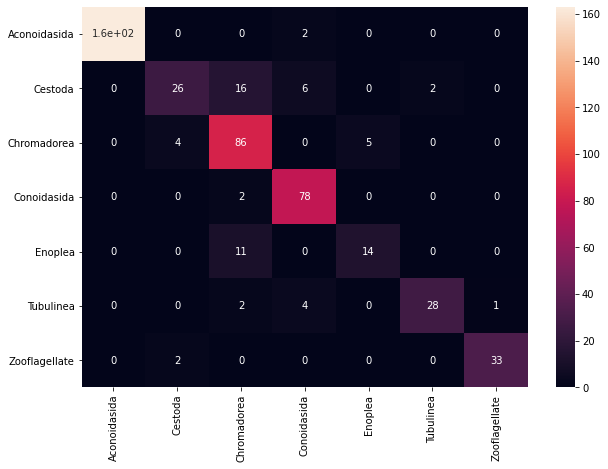

In [14]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
confusion = confusion_matrix(label,preds)
df_cm = pd.DataFrame(confusion, index = le.classes_,
                  columns = le.classes_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

In [ ]:
le.classes_

array(['Aconoidasida', 'Cestoda', 'Chromadorea', 'Conoidasida', 'Enoplea',
       'Tubulinea', 'Zooflagellate'], dtype=object)

In [ ]:
model = ViT.load_from_checkpoint("/content/class-val_loss=0.66-val_accuracy=0.82.ckpt",num_classes_classifier=7,
    train_weights=None,
    val_weights=None,
    train_dataset=None,
    val_dataset=None,
    sampling_rate = [0,0]
    )
model.cuda()
model.eval()

In [15]:
!unzip -q /content/ViT+.zip

### GradCam

In [7]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:  , :].reshape(tensor.size(0), 
        height, width, tensor.size(2))
    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [17]:
!pip install ttach -q

In [13]:
model.img_transformer.blocks[11].norm1

LayerNorm((768,), eps=1e-06, elementwise_affine=True)

In [8]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

target_layer = model.img_transformer.blocks[11].norm1
cam = GradCAMPlusPlus(model=model, use_cuda=True,
                      target_layer=target_layer, 
                      reshape_transform=reshape_transform)

def plot_get(img_path,class_idx,smooth):
  rgb_img = cv2.imread(img_path, 1)[:, :, ::-1]
  rgb_img = cv2.resize(rgb_img, (224, 224))
  rgb_img = np.float32(rgb_img) / 255
  input_tensor = preprocess_image(rgb_img, mean=(0.485, 0.456, 0.406), 
                                          std=(0.229, 0.224, 0.225)).cuda()
  grayscale_cam = cam(input_tensor=input_tensor,
                    target_category=class_idx,
                    eigen_smooth=smooth,
                    aug_smooth=smooth)

  grayscale_cam = grayscale_cam[0, :]
  img_path = img_path.split('/')
  save_path = '/'.join(img_path[:6])+'/'+img_path[4]+'='+img_path[6]    
  cam_image = show_cam_on_image(rgb_img, grayscale_cam)
  cv2.imwrite(save_path, cam_image)
  return Image.fromarray(cam_image)

#### Images

In [28]:
le.classes_

array(['Aconoidasida', 'Cestoda', 'Chromadorea', 'Conoidasida', 'Enoplea',
       'Tubulinea', 'Zooflagellate'], dtype=object)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


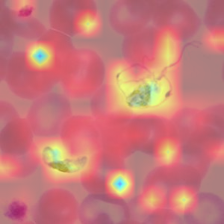

In [11]:
plot_get(
    "/content/ViT/Class/Aconoidasida/Falciparium/Pf_gametocyte_thinF_0_232.jpg",
    0,True
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


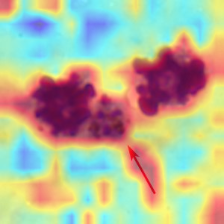

In [13]:
plot_get(
    "/content/ViT/Class/Aconoidasida/Ovale/Po_gametocyte_thickB_0_285.jpg",
    0,False
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


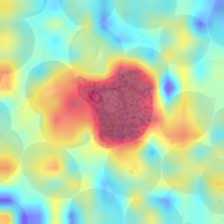

In [16]:
plot_get(
    "/content/ViT/Class/Aconoidasida/Vivax/Pv_troph_thinC_0_312.jpg",
    0,False
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


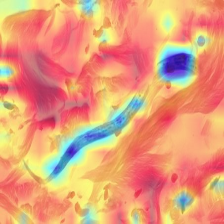

In [33]:
plot_get(
    "/content/ViT/Class/Chromadorea/Stercoralis/S_stercoralis_intbiopsy_400x_BAM1_0_367.jpg",
    6,False
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


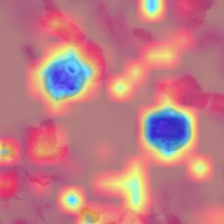

In [25]:
plot_get(
    "/content/ViT/Class/Chromadorea/Stercoralis1K/S_stercoralis_intbiopsy_1000x_BAM1_0_366.jpg",
    None,True
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


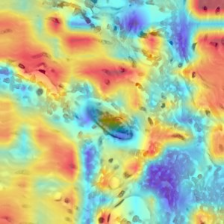

In [35]:
plot_get(
    "/content/ViT/Class/Chromadorea/vermicularis/E_vermicularis_eggs_tissue2_0_157.jpg",
    None, False
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


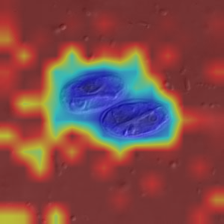

In [39]:
plot_get(
    "/content/ViT/Class/Zooflagellate/Giardia_cyst_dic/Giardia_cyst_dic2_0_165.jpg",
    5,True
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


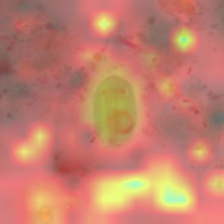

In [59]:
plot_get(
    "/content/ViT/Class/Zooflagellate/Giardia_cyst_tric/Giardia_cyst_tric4_0_174.jpg",
    3,True
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


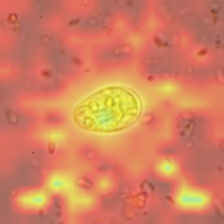

In [60]:
plot_get(
    "/content/ViT/Class/Zooflagellate/Giardia_cyst_wtmt/Giardia_cyst_wtmt4_0_163.jpg",
    None,True
)

In [61]:
!zip -rq ViT++.zip ViT

# Phylum

In [6]:

le = LabelEncoder()

train['phylum_label'] = le.fit_transform(train['phylum'])
val['phylum_label'] = le.transform(val['phylum'])

In [7]:

class_counts = train['phylum_label'].value_counts().to_dict()
train_weights = torch.tensor([1/class_counts[label] for label in train['phylum_label'].values])

train_dataset = SpeciesDataset(train, train_transformer,'phylum')

class_counts = val['phylum_label'].value_counts().to_dict()
val_weights = torch.tensor([1/class_counts[label] for label in val['phylum_label'].values])

val_dataset = SpeciesDataset(val, val_transformer,'phylum')

In [ ]:
le.classes_

array(['Amoebozoa', 'Apicomplexa', 'Nematoda', 'Platyhelminthes',
       'Sarcomastigophora'], dtype=object)

In [8]:
model = ViT(
    num_classes_classifier=5,
    train_weights=train_weights,
    val_weights=val_weights,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    sampling_rate = [3550,1225]
    )

Removing representation layer for fine-tuning.


In [65]:
torch.cuda.empty_cache()

In [66]:
early_stop_callback = EarlyStopping(
   monitor='val_accuracy',
   min_delta=0.00,
   patience=20,
   verbose=False,
   mode='max'
)

model_ckpt = ModelCheckpoint(
    monitor='val_accuracy',
    dirpath='./',
    filename='phylum-{val_loss:.2f}-{val_accuracy:.2f}',
    mode='max')

trainer = pl.Trainer(gpus=1,max_epochs=30,accumulate_grad_batches=4,num_sanity_val_steps=2,callbacks=[early_stop_callback,model_ckpt])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params
------------------------------------------------------
0 | loss_fn         | CrossEntropyLoss  | 0     
1 | img_transformer | VisionTransformer | 85.8 M
------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.210   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

### Accuracy

In [67]:
from sklearn.metrics import classification_report, confusion_matrix

val_dataset = SpeciesDataset(val, val_transformer,'phylum')
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=51)

model = ViT.load_from_checkpoint("/content/phylum-val_loss=0.49-val_accuracy=0.86.ckpt",
                                        num_classes_classifier=5,
                                        train_weights=None,
                                        val_weights=None,
                                        train_dataset=None,
                                        val_dataset=None,
                                        sampling_rate = [0,0]
                                        )
model.cuda()
model.eval()
preds = np.array([])
label = np.array([])
with torch.no_grad():
  for batch in val_loader:
    images = batch["images"].cuda()
    labels = batch['labels']
    label = np.append(label,labels)
    prediction = model(images)
    preds = np.append(preds,prediction.argmax(dim=1).view(labels.size()).cpu().numpy())


print(classification_report(label,preds,target_names=le.classes_))

Removing representation layer for fine-tuning.


                   precision    recall  f1-score   support

        Amoebozoa       0.96      0.77      0.86        35
      Apicomplexa       0.96      0.98      0.97       245
         Nematoda       0.85      0.93      0.89       120
  Platyhelminthes       0.77      0.74      0.76        50
Sarcomastigophora       0.86      0.71      0.78        35

         accuracy                           0.91       485
        macro avg       0.88      0.83      0.85       485
     weighted avg       0.91      0.91      0.90       485



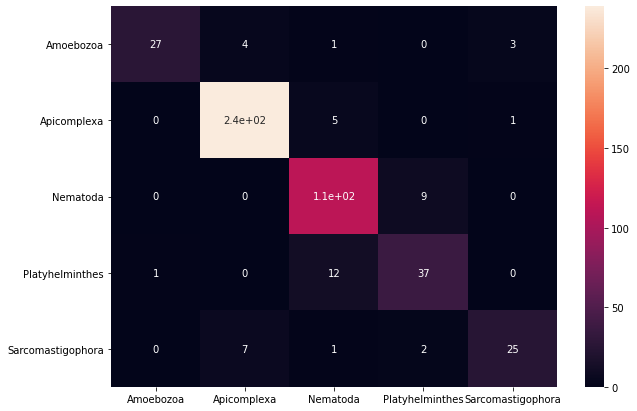

In [68]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
confusion = confusion_matrix(label,preds)
df_cm = pd.DataFrame(confusion, index = le.classes_,
                  columns = le.classes_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

In [9]:
model = ViT.load_from_checkpoint("/content/phylum-val_loss=0.49-val_accuracy=0.86.ckpt",
                                        num_classes_classifier=5,
                                        train_weights=None,
                                        val_weights=None,
                                        train_dataset=None,
                                        val_dataset=None,
                                        sampling_rate = [0,0]
                                        )

Removing representation layer for fine-tuning.


### GradCam

In [ ]:
model.cuda()
model.eval()

In [10]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0), 
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [18]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

target_layer = model.img_transformer.blocks[-1].norm1
cam = GradCAMPlusPlus(model=model, 
                      target_layer=target_layer, 
                      reshape_transform=reshape_transform)

def plot_get(img_path,class_idx,smooth):
  rgb_img = cv2.imread(img_path, 1)[:, :, ::-1]
  rgb_img = cv2.resize(rgb_img, (224, 224))
  rgb_img = np.float32(rgb_img) / 255
  input_tensor = preprocess_image(rgb_img, mean=(0.485, 0.456, 0.406), 
                                          std=(0.229, 0.224, 0.225)).cuda()
  grayscale_cam = cam(input_tensor=input_tensor,
                    target_category=class_idx,
                    eigen_smooth=smooth,
                    aug_smooth=smooth)

  grayscale_cam = grayscale_cam[0, :]
  img_path = img_path.split('/')
  save_path = '/'.join(img_path[:6])+'/'+img_path[4]+'='+img_path[6]    
  cam_image = show_cam_on_image(rgb_img, grayscale_cam)
  cv2.imwrite(save_path, cam_image)
  return Image.fromarray(cam_image)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


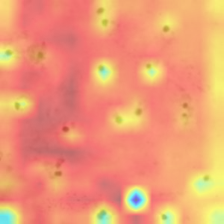

In [19]:
plot_get("/content/ViT/Phylum/Apicomplexa/Pf_rings_thick/Pf_rings_thickC_3_214.jpg",None,False)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


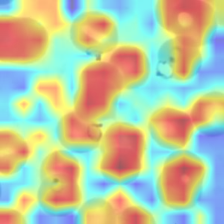

In [74]:
plot_get("/content/ViT/Phylum/Apicomplexa/Pf_rings_thin/Pf_rings_thinE_0_213.jpg",None,False)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


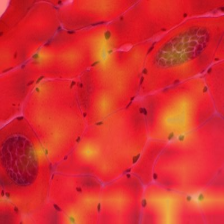

In [77]:
plot_get("/content/ViT/Phylum/Apicomplexa/Sarcocystis/Sarcocystis_muscle_HE_MI_2_rotated_0_345.jpg",1,True)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


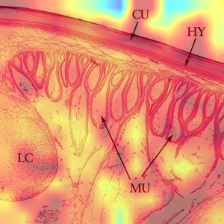

In [80]:
plot_get("/content/ViT/Phylum/Nematoda/Ascaris cuticle/Ascaris_cuticle_cross_section_0_40.jpg",2,True)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


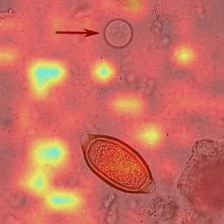

In [84]:
plot_get("/content/ViT/Phylum/Nematoda/Trichuris and Ecoli/Trichuris_and_Ecoli_HB_0_371.jpg",None,True)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


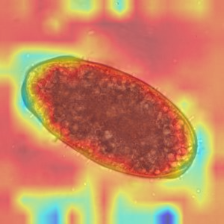

In [98]:
plot_get("/content/ViT/Phylum/Nematoda/lumbricoides/A_lumbricoides_infert_Leiden_B_0_22.jpg",None,False)

In [ ]:
le.classes_

array(['Amoebozoa', 'Apicomplexa', 'Nematoda', 'Platyhelminthes',
       'Sarcomastigophora'], dtype=object)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


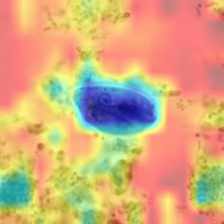

In [101]:
plot_get("/content/ViT/Phylum/Sarcomastigophora/Giardia cyst/Giardia_cyst_tric2_3_169.jpg",4,False)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


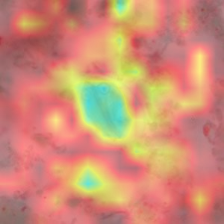

In [103]:
plot_get("/content/ViT/Phylum/Sarcomastigophora/Giardia cyst-2/Giardia_cyst_tric10_0_171.jpg",4,True)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


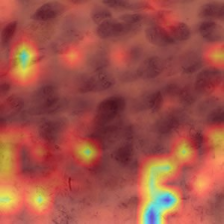

In [21]:
plot_get("/content/ViT/Phylum/Sarcomastigophora/Giardia troph/Giardia_troph_VT_0_181.jpg",4,True)

In [22]:
!zip -r ViT+3.zip ViT

  adding: ViT/ (stored 0%)
  adding: ViT/Phylum/ (stored 0%)
  adding: ViT/Phylum/Sarcomastigophora/ (stored 0%)
  adding: ViT/Phylum/Sarcomastigophora/Giardia cyst/ (stored 0%)
  adding: ViT/Phylum/Sarcomastigophora/Giardia cyst/Giardia_cyst_tric2_3_169.jpg (deflated 2%)
  adding: ViT/Phylum/Sarcomastigophora/Giardia cyst/Sarcomastigophora=Giardia_cyst_tric2_3_169.jpg (deflated 1%)
  adding: ViT/Phylum/Sarcomastigophora/Giardia troph/ (stored 0%)
  adding: ViT/Phylum/Sarcomastigophora/Giardia troph/Sarcomastigophora=Giardia_troph_VT_0_181.jpg (deflated 1%)
  adding: ViT/Phylum/Sarcomastigophora/Giardia troph/Giardia_troph_VT_0_181.jpg (deflated 1%)
  adding: ViT/Phylum/Sarcomastigophora/Giardia cyst-2/ (stored 0%)
  adding: ViT/Phylum/Sarcomastigophora/Giardia cyst-2/Giardia_cyst_tric10_0_171.jpg (deflated 2%)
  adding: ViT/Phylum/Sarcomastigophora/Giardia cyst-2/Sarcomastigophora=Giardia_cyst_tric10_0_171.jpg (deflated 1%)
  adding: ViT/Phylum/Nematoda/ (stored 0%)
  adding: ViT/Phyl

# Species

In [23]:

le = LabelEncoder()

train['species_label'] = le.fit_transform(train['species'])
val['species_label'] = le.transform(val['species'])

In [24]:

class_counts = train['species_label'].value_counts().to_dict()
train_weights = torch.tensor([1/class_counts[label] for label in train['species_label'].values])

train_dataset = SpeciesDataset(train, train_transformer,'species')

class_counts = val['species_label'].value_counts().to_dict()
val_weights = torch.tensor([1/class_counts[label] for label in val['species_label'].values])

val_dataset = SpeciesDataset(val, val_transformer,'species')

In [ ]:
len(le.classes_)

16

In [25]:
model = ViT(
    num_classes_classifier=16,
    train_weights=train_weights,
    val_weights=val_weights,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    sampling_rate = [2160,720]
    )

Removing representation layer for fine-tuning.


In [26]:
early_stop_callback = EarlyStopping(
   monitor='val_accuracy',
   min_delta=0.00,
   patience=20,
   verbose=False,
   mode='max'
)

model_ckpt = ModelCheckpoint(
    monitor='val_accuracy',
    dirpath='./',
    filename='species-{val_loss:.2f}-{val_accuracy:.2f}',
    mode='max')

trainer = pl.Trainer(gpus=1,max_epochs=30,accumulate_grad_batches=4,num_sanity_val_steps=2,callbacks=[early_stop_callback,model_ckpt])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params
------------------------------------------------------
0 | loss_fn         | CrossEntropyLoss  | 0     
1 | img_transformer | VisionTransformer | 85.8 M
------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.244   Total estimated model params size (MB)


1

### Accuracy

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

val_dataset = SpeciesDataset(val, val_transformer,'species')
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=51)

model = ViT.load_from_checkpoint("/content/species-val_loss=1.00-val_accuracy=0.77.ckpt",
                                        num_classes_classifier=16,
                                        train_weights=None,
                                        val_weights=None,
                                        train_dataset=None,
                                        val_dataset=None,
                                        sampling_rate = [0,0]
                                        )
model.cuda()
model.eval()
preds = np.array([])
label = np.array([])
with torch.no_grad():
  for batch in val_loader:
    images = batch["images"].cuda()
    labels = batch['labels']
    label = np.append(label,labels)
    prediction = model(images)
    preds = np.append(preds,prediction.argmax(dim=1).view(labels.size()).cpu().numpy())


print(classification_report(label,preds,target_names=le.classes_))

Removing representation layer for fine-tuning.


                           precision    recall  f1-score   support

         Ancyclostoma sp.       0.79      0.95      0.86        20
     Ascaris lumbricoides       0.93      0.80      0.86        35
      Cryptosporidium sp.       0.92      0.55      0.69        20
  Cyclospora cayetanensis       0.91      0.97      0.94        40
  Dibothriocephalus latus       0.52      0.68      0.59        25
    Entamoeba histolytica       0.60      0.97      0.74        35
  Enterobius vermicularis       0.42      0.25      0.31        20
       Giardia duodenalis       0.90      0.77      0.83        35
          Hymenolepis spp       0.92      0.44      0.59        25
    Plasmodium falciparum       0.68      0.71      0.70        45
      Plasmodium malariae       0.80      0.50      0.62        40
         Plasmodium ovale       0.54      0.74      0.63        35
         Plasmodium vivax       0.78      0.78      0.78        45
          Sarcocystis sp.       1.00      0.90      0.95     

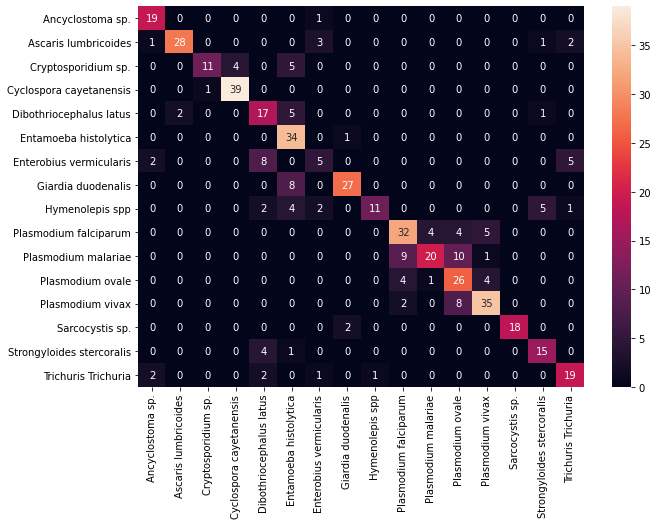

In [28]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
confusion = confusion_matrix(label,preds)
df_cm = pd.DataFrame(confusion, index = le.classes_,
                  columns = le.classes_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

In [ ]:
!unzip -q /content/ResNet200D.zip

### GradCam

In [29]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0), 
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [30]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

target_layer = model.img_transformer.blocks[-1].norm1
cam = GradCAMPlusPlus(model=model, 
                      target_layer=target_layer, 
                      reshape_transform=reshape_transform)

def plot_get(img_path,class_idx,smooth):
  rgb_img = cv2.imread(img_path, 1)[:, :, ::-1]
  rgb_img = cv2.resize(rgb_img, (224, 224))
  rgb_img = np.float32(rgb_img) / 255
  input_tensor = preprocess_image(rgb_img, mean=(0.485, 0.456, 0.406), 
                                          std=(0.229, 0.224, 0.225)).cuda()
  grayscale_cam = cam(input_tensor=input_tensor,
                    target_category=class_idx,
                    eigen_smooth=smooth,
                    aug_smooth=smooth)

  grayscale_cam = grayscale_cam[0, :]
  img_path = img_path.split('/')
  save_path = '/'.join(img_path[:6])+'/'+img_path[4]+'='+img_path[6]    
  cam_image = show_cam_on_image(rgb_img, grayscale_cam)
  cv2.imwrite(save_path, cam_image)
  return Image.fromarray(cam_image)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


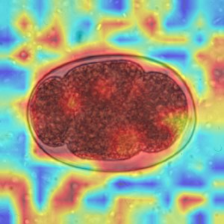

In [39]:
plot_get("/content/ViT/Species/Ancyclostoma/Hookworm/Hookworm_2x2_B_0_3.jpg",None,False)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


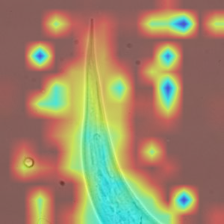

In [44]:
plot_get("/content/ViT/Species/Ancyclostoma/Hookworm_filariform/Hookworm_filariform_posterior_A_0_11.jpg",None,True)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


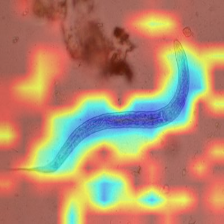

In [47]:
plot_get("/content/ViT/Species/Ancyclostoma/Hookworm_rhabditiform/Hookworm_rhabditiform_2_0_7.jpg",None,True)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


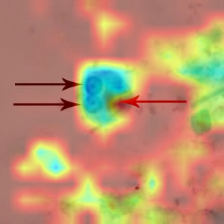

In [52]:
plot_get("/content/ViT/Species/Entamoeba/Ehistdisp cyst/Ehistdisp_cyst_tric3_0_120.jpg",None,True)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


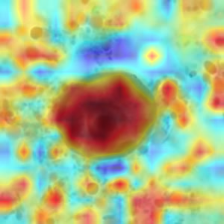

In [57]:
plot_get("/content/ViT/Species/Entamoeba/Ehistdisp cyst tric/Ehistdisp_cyst_tric6_KS_0_123.jpg",5,False)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


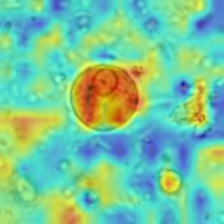

In [62]:
plot_get("/content/ViT/Species/Entamoeba/Ehistdisp cyst wtmt/Ehistdisp_cyst_wtmt_0_115.jpg",5,False)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


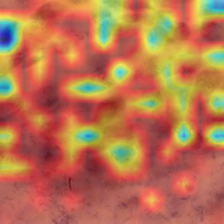

In [66]:
plot_get("/content/ViT/Species/Giardia duodenalis/Giardia troph/Giardia_troph_VT_0_181.jpg",None,False)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


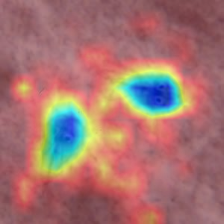

In [67]:
plot_get("/content/ViT/Species/Giardia duodenalis/Giardia troph kohn/Giardia_troph_kohn_0_182.jpg",7,True)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


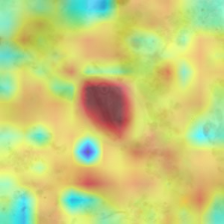

In [71]:
plot_get("/content/ViT/Species/Giardia duodenalis/Giardia_cyst_tric/Giardia_cyst_tric10_0_171.jpg",None,False)

In [ ]:
!zip -r ResNet200D.zip ResNet200D

In [78]:
!7z a ViT-Weights.7z /content/phylum-val_loss=0.49-val_accuracy=0.86.ckpt /content/species-val_loss=1.00-val_accuracy=0.77.ckpt


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Open archive: ViT-Weights.7z
--
Path = ViT-Weights.7z
Type = 7z
Physical Size = 937174225
Headers Size = 194
Method = LZMA2:24
Solid = -
Blocks = 1

Scanning the drive:
  0M Scan  /content/                    2 files, 2059683282 bytes (1965 MiB)

Updating archive: ViT-Weights.7z

Items to compress: 2

  0%      5% = class-val_loss=0.66-val_accuracy=0.82.ckpt                                                   9% = class-val_loss=0.66-val_accuracy=0.82.ckpt                                                  11% = class-val_loss=0.66-val_accuracy=0.82.ckpt

In [77]:
!zip -r ViT4+.zip /content/ViT

  adding: content/ViT/ (stored 0%)
  adding: content/ViT/Phylum/ (stored 0%)
  adding: content/ViT/Phylum/Sarcomastigophora/ (stored 0%)
  adding: content/ViT/Phylum/Sarcomastigophora/Giardia cyst/ (stored 0%)
  adding: content/ViT/Phylum/Sarcomastigophora/Giardia cyst/Giardia_cyst_tric2_3_169.jpg (deflated 2%)
  adding: content/ViT/Phylum/Sarcomastigophora/Giardia cyst/Sarcomastigophora=Giardia_cyst_tric2_3_169.jpg (deflated 1%)
  adding: content/ViT/Phylum/Sarcomastigophora/Giardia troph/ (stored 0%)
  adding: content/ViT/Phylum/Sarcomastigophora/Giardia troph/Sarcomastigophora=Giardia_troph_VT_0_181.jpg (deflated 1%)
  adding: content/ViT/Phylum/Sarcomastigophora/Giardia troph/Giardia_troph_VT_0_181.jpg (deflated 1%)
  adding: content/ViT/Phylum/Sarcomastigophora/Giardia cyst-2/ (stored 0%)
  adding: content/ViT/Phylum/Sarcomastigophora/Giardia cyst-2/Giardia_cyst_tric10_0_171.jpg (deflated 2%)
  adding: content/ViT/Phylum/Sarcomastigophora/Giardia cyst-2/Sarcomastigophora=Giardia_c